In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *

import matplotlib.pyplot as plt


#np.set_printoptions(precision=4)
import math
from utils import *

size = 8
nA = 2
seed = get_current_seed()
gamma = .9
mu = np.ones(size) * 1/size
river = River(size, mu, gamma=gamma, small=5, large=1000, seed=seed)
tau = 0.5
xi = np.ones(size) * 1/size
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
mdp = TMDP(river, xi, tau=0., gamma=gamma, seed=seed)


Current seed for result reproducibility: 217014191819363466859807231163974931299


In [2]:
Q_star, _ = bellman_optimal_q(tmdp.P_mat_tau, tmdp.env.reward, gamma).values()
pi = get_policy(Q_star)
print(Q_star)

[[192.32880525 189.13661796]
 [189.51630549 188.20638369]
 [188.25068062 187.66121581]
 [187.68114945 187.6218458 ]
 [187.42486044 188.95045693]
 [187.99604883 196.44325045]
 [191.36780594 236.53673494]
 [209.40987398 450.84094187]]


In [3]:
def bellman_optimal_q_tau(P_mat, xi, reward, gamma, tau, threshold=1e-6):
    size, nA, _ = P_mat.shape
    r_s_a = compute_r_s_a(P_mat, reward)
    r_s_a_xi = compute_r_s_a(xi, reward)

    Q = np.zeros((size, nA))
    Q_p = np.zeros((size, nA))
    Q_xi = np.zeros((size, nA))
    iterations = 0
    done = False
    while not done:
        Q_old = Q.copy()
        for s in range(size):
            for a in range(nA):
                Q_p[s,a] = r_s_a[s,a] + gamma * np.dot(P_mat[s,a,:], np.max(Q, axis=1))
                Q_xi[s,a] = r_s_a_xi[s,a] + gamma * np.dot(xi, np.max(Q, axis=1))
                Q[s,a] = (1-tau)*Q_p[s,a] + tau*Q_xi[s,a]
        iterations += 1 
        epsilon = np.linalg.norm(Q - Q_old, np.inf)
        if epsilon <= threshold:
            done = True
    return {"Q": Q, "Q_p":Q_p, "Q_xi": Q_xi, "iterations": iterations}

In [4]:

def compute_gradient_q_tau(P_mat, xi, reward, mu, gamma, tau):
    size, nA, _ = P_mat.shape

    Xi = np.tile(xi, (nA, size)).T
    Xi = Xi.reshape((size, nA, size))
    P_mat_tau = (1-tau)*P_mat + tau*xi

    res = bellman_optimal_q_tau(P_mat, xi, reward, gamma, tau)
    Q_p = res["Q_p"]
    Q_xi = res["Q_xi"]
    Q_tau = res["Q"]
    pi = get_policy(Q_tau)

    r_s_a = compute_r_s_a(P_mat, reward)
    r_s_a_xi = compute_r_s_a(xi, reward)
    
    d = compute_d_from_tau(mu, P_mat, xi, pi, gamma, tau)
    delta_r = r_s_a_xi - r_s_a

    grad_q = np.zeros_like(Q_p)
    sum_q = np.zeros(size)
    for s in range(size):
        for a in range(nA):
            sum_q[s] += pi[s,a]*(Q_xi[s,a] - Q_p[s,a])
    for s in range(size):
        for a in range(nA):
            for s_prime in range(size):
                grad_q[s,a] += (P_mat_tau[s,a,s_prime] + gamma/(1-gamma)*d[s_prime])*sum_q[s_prime]
            grad_q[s,a] = grad_q[s,a]*gamma + delta_r[s,a]
            

    return grad_q


In [5]:
bellman_tau = bellman_optimal_q_tau(tmdp.env.P_mat, tmdp.xi, tmdp.env.reward, gamma, tau)
print(bellman_tau["Q_p"])
print(bellman_tau["Q_xi"])
print(bellman_tau["Q"])

[[178.09592431 172.33654968]
 [173.09592473 170.47608109]
 [170.56467494 169.38574527]
 [169.42561255 169.30700522]
 [168.9130345  171.96422748]
 [170.05541124 186.94981447]
 [176.79892541 267.1367834 ]
 [212.88306144 570.74519721]]
[[206.56168619 205.93668625]
 [205.93668625 205.93668629]
 [205.93668629 205.93668634]
 [205.93668634 205.93668638]
 [205.93668638 205.93668638]
 [205.93668643 205.93668643]
 [205.93668647 205.93668647]
 [205.93668652 330.93668652]]
[[192.32880525 189.13661796]
 [189.51630549 188.20638369]
 [188.25068062 187.66121581]
 [187.68114945 187.6218458 ]
 [187.42486044 188.95045693]
 [187.99604883 196.44325045]
 [191.36780594 236.53673494]
 [209.40987398 450.84094187]]


In [6]:
grad_q = compute_gradient_q_tau(tmdp.env.P_mat, tmdp.xi, tmdp.env.reward, tmdp.env.mu, gamma, tau)
print(grad_q)

[[-103.28767468  -98.32204973]
 [ -98.91267468  -96.7990811 ]
 [ -96.94392485  -95.76499524]
 [ -95.80486242  -95.68625515]
 [ -95.29228433  -98.34347759]
 [ -96.43466103 -113.32906454]
 [-103.17817515 -159.76603341]
 [-139.26231115 -338.37444701]]


In [7]:
status_step = 5000
episodes = 100000
batch_size = 1
temperature = 20

In [8]:
"""tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
Q = np.zeros((size, nA))
Qs = Q_learning(tmdp, Q, alpha=.25, episodes=episodes, status_step=status_step)"""

'tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)\nQ = np.zeros((size, nA))\nQs = Q_learning(tmdp, Q, alpha=.25, episodes=episodes, status_step=status_step)'

In [9]:
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
Q = np.zeros((size, nA))
batch_Qs = batch_q_learning(tmdp, Q, alpha=.25, episodes=episodes, status_step=status_step, batch_size=batch_size)

In [10]:
Q_p=np.zeros((size, nA))
Q_xi = np.zeros((size, nA))
pg_res = policy_gradient(tmdp, Q_p, Q_xi, alpha=0.25, episodes=episodes, status_step=status_step, batch_size=batch_size, temperature=temperature)


In [11]:
Q_p=np.zeros((size, nA))
Q_xi = np.zeros((size, nA))
double_q = batch_double_q_learning(tmdp, Q_p, Q_xi, alpha=0.25, episodes=episodes, status_step=status_step, batch_size=batch_size)


In [12]:
#print(batch_Qs["Qs"][-1])
#print(pg_res["Qs"][-1])
print(double_q["Qs"][-1])
print(double_q["Q_ps"][-1])
print(double_q["Q_xis"][-1])
#print(Q_star)

[[132.32669366 128.90827016]
 [129.64599828 128.30357546]
 [129.73475129 128.07857597]
 [129.91579004 129.50319258]
 [128.96880137 129.99642912]
 [131.41765329 131.27737622]
 [143.00129354 154.63958298]
 [125.28793747 306.13924539]]
[[123.9144384  122.46980494]
 [119.77717657 118.82505984]
 [119.21255815 119.13075247]
 [119.85549205 118.05780148]
 [119.7636979  119.07042586]
 [121.16379545 125.71644523]
 [135.66122982 169.22494375]
 [120.48727983 454.55106123]]
[[140.73894892 135.34673538]
 [139.51481998 137.78209109]
 [140.25694443 137.02639948]
 [139.97608804 140.94858368]
 [138.17390484 140.92243238]
 [141.67151114 136.8383072 ]
 [150.34135727 140.05422221]
 [130.08859511 157.72742955]]


In [13]:
tau_prime = 0.
pg_metrics = compute_metrics(tmdp, pg_res["Qs"], Q_star, pg_res["disc_visits_distributions"], tau_prime=tau_prime)#, is_policy=True, temperature=temperature)
batch_metrics = compute_metrics(tmdp, batch_Qs["Qs"], Q_star, batch_Qs["disc_visits_distributions"], tau_prime=tau_prime)
double_q_metrics = compute_metrics(tmdp, double_q["Qs"], Q_star, double_q["disc_visits_distributions"], tau_prime=tau_prime)
double_q_metrics_p = compute_metrics(tmdp, double_q["Q_ps"], Q_star, double_q["disc_visits_distributions"], tau_prime=tau_prime)

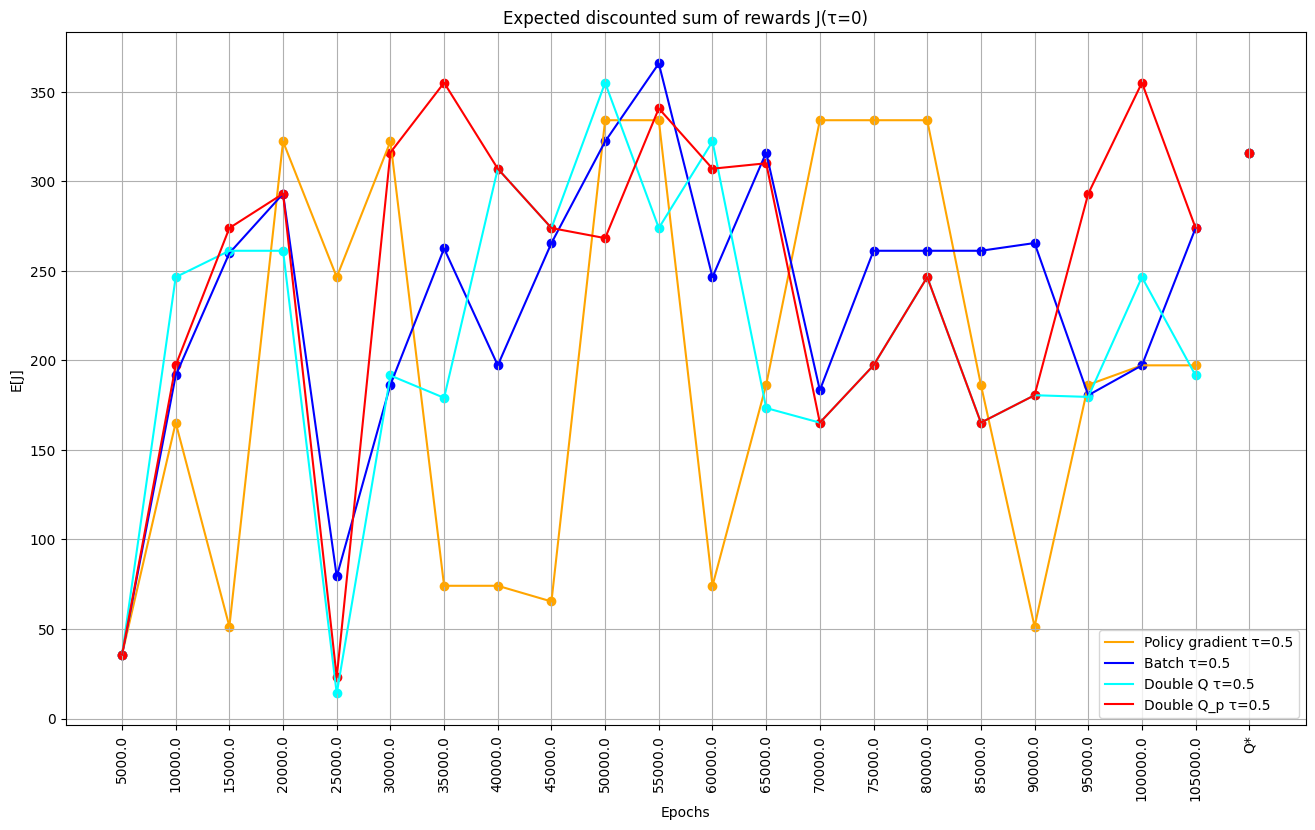

In [14]:
x = np.array([])
y_0 = np.array([])
y = np.array([])
y_d = np.array([])
y_p = np.array([])

for i, J in enumerate(pg_metrics["J"]):
    y = np.append(y, J)
    y_0 = np.append(y_0, batch_metrics["J"][i])
    y_d = np.append(y_d, double_q_metrics["J"][i])
    y_p = np.append(y_p, double_q_metrics_p["J"][i])
    if i < len(batch_metrics["J"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.figure(figsize=(16,9))
plt.xticks(rotation=90, fontsize=10)
plt.scatter(x, y, c="orange")
plt.scatter(x, y_0, c="blue")
plt.scatter(x, y_d, c="cyan")
plt.scatter(x, y_p, c="red")

plt.plot(x[:-1], y[:-1], c="orange", label="Policy gradient τ={}".format(tmdp.tau))
plt.plot(x[:-1], y_0[:-1], c="blue", label="Batch τ={}".format(tmdp.tau))
plt.plot(x[:-1], y_d[:-1], c="cyan", label="Double Q τ={}".format(tmdp.tau))
plt.plot(x[:-1], y_p[:-1], c="red", label="Double Q_p τ={}".format(tmdp.tau))
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("E[J]")
plt.title("Expected discounted sum of rewards J(τ=0)")
plt.grid(visible=True)


In [15]:
print(batch_Qs["disc_visits_distributions"][-1])
print(batch_Qs["visits_distributions"][-2])

d = compute_d_from_tau(tmdp.mu, tmdp.P_mat_tau, tmdp.xi, get_policy(Q_star, False), tmdp.gamma, tmdp.tau)
print(d)

[0.21871181 0.11453666 0.10174813 0.07332919 0.10175975 0.1229915
 0.16213836 0.1047846 ]
[0.2134538  0.13694952 0.14007708 0.13989806 0.12458668 0.11807881
 0.11746804 0.00948801]


AttributeError: 'TMDP' object has no attribute 'mu'